## Loading of Steinmetz data

includes some visualizations

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.decomposition import PCA
from statsmodels.formula.api import ols
import pandas as pd

In [3]:
from util import fetch_data_if_not_exist

files = [f"steinmetz_part{i}.npz" for i in range(3)]
urls = [
    "https://osf.io/agvxh/download",
    "https://osf.io/uv3mw/download",
    "https://osf.io/ehmw2/download",
]

for file_name, url in zip(files, urls):
    fetch_data_if_not_exist(file_name, url)

In [4]:
# @title Data loading
alldata = np.array([])
for file in files:
    data = np.load(file, allow_pickle=True)["dat"] # np.load(file).files = ["dat"]
    alldata = np.hstack((alldata, data))
n_alldata = len(alldata)

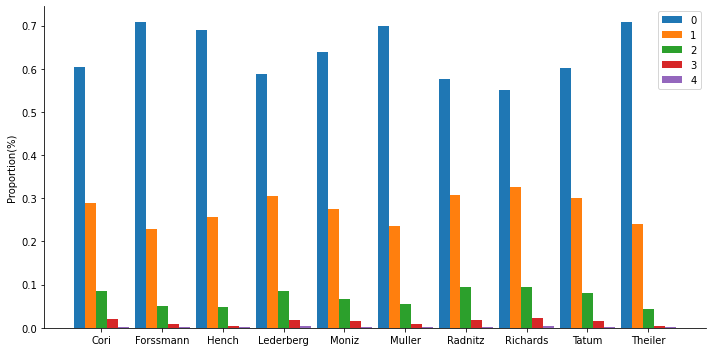

In [63]:
np.random.seed(2022)

mice_name = []
type_amount = np.array

non_ecd_amount, ecd_one_amount, ecd_two_amount, ecd_thr_amount, ecd_four_amount = [[] for x in range(5)]

for session in range(39):

    dat = alldata[session]
    mouse_name = dat['mouse_name']
    neurons_amount = len(dat['spks'])
        
    encoding_one, encoding_two, encoding_three, encoding_four = [0 for x in range(4)]

    # the index of each session [format: 1-d np.array, the index of neuron in the certain session]
    visual_index = np.random.randint(0, neurons_amount, np.random.randint(0, 300, 1))
    action_index = np.random.randint(0, neurons_amount, np.random.randint(0, 200, 1))  
    choice_index = np.random.randint(0, neurons_amount, np.random.randint(0, 150, 1))
    reward_index = np.random.randint(0, neurons_amount, np.random.randint(0, 200, 1))

    # the amount of each type of neurons
    all_encoding = list(np.concatenate([visual_index, action_index, choice_index, reward_index], axis = None))
    counter = [[x, all_encoding.count(x)] for x in set(all_encoding)]
    for l in counter:
        if l[1] == 1:
            encoding_one += 1
        elif l[1] == 2:
            encoding_two += 1
        elif l[1] == 3:
            encoding_three += 1
        elif l[1] == 4:
            encoding_four += 1

    non_encoding = len(set(range(neurons_amount))-set(all_encoding))

    if mouse_name in mice_name:
        non_ecd_amount[-1] += non_encoding
        ecd_one_amount[-1] += encoding_one
        ecd_two_amount[-1] += encoding_two
        ecd_thr_amount[-1] += encoding_three
        ecd_four_amount[-1] += encoding_four
    else:
        mice_name.append(mouse_name)
        non_ecd_amount.append(non_encoding)
        ecd_one_amount.append(encoding_one)
        ecd_two_amount.append(encoding_two)
        ecd_thr_amount.append(encoding_three)
        ecd_four_amount.append(encoding_four)
            
# cauculate the proportion
for i in range(len(non_ecd_amount)):
    ttl = non_ecd_amount[i] + ecd_one_amount[i] + ecd_two_amount[i] + ecd_thr_amount[i] + ecd_four_amount[i]
    non_ecd_amount[i] /= ttl  
    ecd_one_amount[i] /= ttl
    ecd_two_amount[i] /= ttl
    ecd_thr_amount[i] /= ttl
    ecd_four_amount[i] /= ttl

plt.figure(figsize=(10,5))
x = np.arange(len(mice_name)) 
width = 0.18 
plt.bar(x - 2 * width, non_ecd_amount, width, label='0')
plt.bar(x - width, ecd_one_amount, width, label='1')
plt.bar(x , ecd_two_amount, width, label='2')
plt.bar(x + width, ecd_thr_amount, width, label='3')
plt.bar(x + 2 * width, ecd_four_amount, width, label='4')
plt.ylabel('Proportion(%)')
# plt.title('Proportion of each type of neurons')
plt.xticks(x, labels=mice_name)
plt.legend()

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406